In [1]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('hw1data/propublicaTrain.csv')
test = pd.read_csv('hw1data/propublicaTest.csv')

# 5.4.3 Naive Bayes

In [3]:
# Preprocessing
def preprocess(df):
    '''Remove c_charge_degree_M column due to redunduncy'''
    return df.drop(labels=['c_charge_degree_M'], axis=1)

In [4]:
def naive_bayes_train(df, features, target='two_year_recid', k=1):
    """returns class conditional probability distribution and class prior as dictionaries"""
    # initialize variables
    sample_size, feature_dim = df.shape[0], len(features)
    # print('sample_size, feature_dim: ', sample_size, feature_dim)
    y_count = {} # {key = label : value = count of label in sample},
    x_count = {} # dict of dicts of dicts = {key=label:value={key=feature:value={key=feature_val:value=count}}}
    feature_given_class = {} # Pr[X=x|Y=y]
    class_prior = {} # Pr[Y=y]
    
    # initialize dictionary keys
    for label in df[target].unique():
        y_count[label], class_prior[label] = 0, 0
        x_count[label], feature_given_class[label] = {}, {}
        for feature in features:
            x_count[label][feature], feature_given_class[label][feature] = {}, {}
    
    # print('y_count: ', y_count)
    # print('x_count: ', x_count)
    
    # update dictionary values
    for index, row in df.iterrows():
        label = row[target]
        y_count[label] += 1
        for feature in features:
            feature_val = row[feature]
            if feature_val in x_count[label][feature].keys():
                x_count[label][feature][feature_val] += 1
            else:
                x_count[label][feature][feature_val] = 1
    
    # print('y_count: ', y_count)
    # print('x_count: ', x_count)
    
    # find class prior probabilities
    for label in class_prior.keys():
        class_prior[label] = y_count[label]/sample_size
    
    # find feature given class probabilities with additive smoothing
    for label in feature_given_class.keys():
        for feature in feature_given_class[label].keys():
            for feature_val in x_count[label][feature].keys():
                feature_given_class[label][feature][feature_val] = \
                (x_count[label][feature][feature_val] + k) / (y_count[label] + k * feature_dim)
    # print('class prior: ', class_prior)
    # print('f|c: ', feature_given_class)
    return class_prior, feature_given_class, y_count

In [5]:
def predict(series, features, class_prior, feature_given_class, y_count, k=1):
    """given a series, return a belief distribution over possible labels"""
    belief = {}
    for label in class_prior.keys():
        prob = class_prior[label]
        for feature in features:
            feature_val = series[feature]
            # print(feature, feature_val)
            if feature_val in feature_given_class[label][feature]:
                prob *= feature_given_class[label][feature][feature_val]
            else:
                prob *= k/(y_count[label] + k * len(features))
        belief[label] = prob
    return belief

In [6]:
def evaluate(df, features, class_prior, feature_given_class, y_count, target = 'two_year_recid'):
    total_pred, accurate_pred = 0, 0
    y_preds = []
    for index, row in df.iterrows():
        y = row[target]
        belief = predict(row, features, class_prior, feature_given_class, y_count)
        y_pred = max(belief.items(), key=operator.itemgetter(1))[0]
        total_pred += 1
        if y_pred == y:
            accurate_pred += 1
        y_preds.append(y_pred)
    y_pred_df = pd.DataFrame({'prediction': y_preds})
    df = pd.concat([df, y_pred_df], axis=1)
    accuracy = accurate_pred/total_pred
    return accuracy, df

In [7]:
def perform_naive_bayes(train, test):
    train = preprocess(train)
    test = preprocess(test)
    features = list(train)[1:]
    class_prior, feature_given_class, y_count = naive_bayes_train(train, features)
    return evaluate(test, features, class_prior, feature_given_class, y_count)

# 5.4.1 MLE

# 5.5 Which classifier is beter for this prediction task?

In [11]:
# define numbers of training samples we are interested in
training_samples_nums = [25,100,200]
l = [463*i for i in range(1,10)]
training_samples_nums = training_samples_nums + l
training_samples_nums

[25, 100, 200, 463, 926, 1389, 1852, 2315, 2778, 3241, 3704, 4167]

In [12]:
# find accuracies of classifiers
bayes_accuracies = []
for number in training_samples_nums:
    new_train = train.sample(number)
    accuracy, _ = perform_naive_bayes(new_train, test)
    bayes_accuracies.append(accuracy)

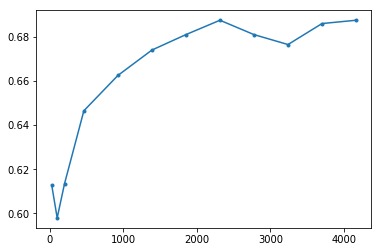

In [13]:
plt.plot(training_samples_nums, bayes_accuracies, '.-')
plt.show()